# Trabajo Práctico: Modelado Comparativo en Minería de Datos


En este trabajo vamos a analizar un dataset que contiene información sobre hábitos de estudiantes universitarios y su rendimiento académico. El objetivo de este notebook es aplicar técnicas de minería de datos para construir un modelo de clasificación que permita predecir una variable categórica a partir del resto de los datos.

Se utilizara color 🟡 para visualizaciones compartidas

Se utilizara color 🔵 para visualizaciones unicamente de regresion

Se utilizara color 🟢 para visualizaciones unicamente de clasificacion

## Descripción General del Problema


En este trabajo vamos a analizar un dataset que contiene información sobre estudiantes universitarios: sus hábitos, condiciones personales, estilo de vida y desempeño en los exámenes. A partir de esos datos, vamos a crear una nueva columna llamada `exam_performance`, que clasifica a los alumnos en tres grupos: alto, medio o bajo rendimiento.

La idea es usar esta variable para entrenar modelos de clasificación y ver si, con la información disponible, podemos anticipar en qué grupo de rendimiento podría estar un estudiante. Pero el análisis no termina ahí: además de **clasificar**, también nos interesa construir un modelo de **regresión** que prediga directamente el puntaje del examen (`exam_score`), que en este caso es una variable numérica.

Este enfoque combinado nos permite tener una mirada más completa: por un lado, identificar patrones generales que expliquen el rendimiento académico, y por otro, hacer estimaciones más precisas que podrían servir como herramienta de apoyo para tomar decisiones, detectar posibles casos de riesgo o simplemente entender mejor qué factores están influyendo en los resultados.

## 1. Importación de librerias



In [182]:
# Importamos las librerías

import pandas as pd  # para trabajar con datos en forma de tabla
import numpy as np   # para operaciones numéricas

from scipy.stats import f_oneway   # para realizar pruebas estadísticas ANOVA entre grupos


# Graficos
import matplotlib.pyplot as plt  
import seaborn as sns            

#sklearn preparacion
from sklearn.preprocessing import StandardScaler, LabelEncoder  
from sklearn.model_selection import train_test_split , cross_val_score 
from sklearn.decomposition import PCA  

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression, LinearRegression         
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor               # clasificador tipo árbol de decisión
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor            # clasificador de bosque aleatorio


# Métricas de evaluacion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score

# Selección de variables 
from sklearn.feature_selection import SelectKBest, chi2, f_classif

## 2. Carga del dataset


In [183]:
#Si se usa Colab ejecutar esta celda
"""
from google.colab import files

uploaded = files.upload()
"""

'\nfrom google.colab import files\n\nuploaded = files.upload()\n'

In [184]:
# Si se carga el archivo local, ajustar ruta en caso de necesitar
df = pd.read_csv('student_habits_performance_2.csv')

## 3. Resumen y Tratamiento de Datos Inicial


### 3.1 Resumen general del dataset y características


In [185]:
# ========================
# 1. Dimensiones del dataset
# ========================
print("1. Dimensiones del dataset")
print(f"Filas: {df.shape[0]}  |  Columnas: {df.shape[1]}")
print("-" * 50)

# ========================
# 2. Filas del dataset
# ========================
print("2. Primeras filas del dataset")
display(df.head())
print("-" * 50)

# ========================
# 3. Información general del dataset
# ========================
print("3. Información general del dataset")
df.info()
print("-" * 50)

1. Dimensiones del dataset
Filas: 10000  |  Columnas: 16
--------------------------------------------------
2. Primeras filas del dataset


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


--------------------------------------------------
3. Información general del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     10000 non-null  object 
 1   age                            10000 non-null  int64  
 2   gender                         10000 non-null  object 
 3   study_hours_per_day            10000 non-null  float64
 4   social_media_hours             10000 non-null  float64
 5   netflix_hours                  10000 non-null  float64
 6   part_time_job                  10000 non-null  object 
 7   attendance_percentage          10000 non-null  float64
 8   sleep_hours                    10000 non-null  float64
 9   diet_quality                   10000 non-null  object 
 10  exercise_frequency             10000 non-null  int64  
 11  parental_education_le

In [186]:
# ========================
# 4. Valores nulos por columna
# ========================
print("4. Valores nulos por columna")
nulls = df.isnull().sum()
nulls = nulls[nulls > 0]

if not nulls.empty:
    print("Se encontraron columnas con valores nulos:")
    display(pd.DataFrame(nulls, columns=["Valores nulos"]))
else:
    print("No se encontraron valores nulos.")
print("-" * 50)

# ========================
# 5. Filas duplicadas
# ========================
print("5. Filas duplicadas")
print(f"Cantidad de filas duplicadas: {df.duplicated().sum()}")
print("-" * 50)

# ========================
# 6. Categorías únicas por variable categórica
# ========================
print("6. Categorías únicas por cada variable categórica")
for col in df.select_dtypes(include="object").columns:
    print(f"\n {col} ({df[col].nunique()} categorías):")
    print(df[col].value_counts())
    print("-" * 30)

4. Valores nulos por columna
Se encontraron columnas con valores nulos:


,Valores nulos
parental_education_level,952


--------------------------------------------------
5. Filas duplicadas
Cantidad de filas duplicadas: 0
--------------------------------------------------
6. Categorías únicas por cada variable categórica

 student_id (1000 categorías):
student_id
S1725    21
S1775    19
S1072    19
S1890    19
S1038    19
         ..
S1696     3
S1239     3
S1218     3
S1023     2
S1544     2
Name: count, Length: 1000, dtype: int64
------------------------------

 gender (3 categorías):
gender
Male      4908
Female    4660
Other      432
Name: count, dtype: int64
------------------------------

 part_time_job (2 categorías):
part_time_job
No     7832
Yes    2168
Name: count, dtype: int64
------------------------------

 diet_quality (3 categorías):
diet_quality
Fair    4321
Good    3868
Poor    1811
Name: count, dtype: int64
------------------------------

 parental_education_level (3 categorías):
parental_education_level
High School    3929
Bachelor       3463
Master         1656
Name: count, dtype: i

A partir del análisis exploratorio realizado, se obtienen las siguientes observaciones clave:

- **Cantidad de datos:** el dataset cuenta con 10,000 registros y 16 columnas, una cantidad adecuada para aplicar técnicas de clasificación de forma robusta.

- **Tipos de variables:** se identifican variables numéricas (`int64`, `float64`) como `age`, `study_hours_per_day`, `exam_score`, y variables categóricas (`object`) como `gender`, `diet_quality`, `internet_quality`, entre otras. 

- **Primeras filas:** los datos iniciales presentan valores lógicos y bien distribuidos, sin errores de carga visibles.

- **Valores nulos:** se detectaron 952 valores nulos en la variable `parental_education_level`, representando un 9.5% del total. Este porcentaje es manejable, y se optará por imputarlos con una categoría adicional denominada `"No declarado"` para no eliminar datos ni introducir supuestos artificiales.

- **Filas duplicadas:** no se encontraron registros duplicados en el dataset (`0` filas duplicadas), lo que refleja una buena calidad estructural.

- **Formato general:** los nombres de las columnas son claros y coherentes con los datos que representan. No se identifican errores de formato ni estructuras inconsistentes.

- **Categorías únicas:** Se revisaron todas las variables categóricas del dataset para identificar cuántas categorías distintas tiene cada una y evaluar su utilidad para el análisis.

`student_id`: presenta 1000 valores únicos, funcionando como un identificador por estudiante. En algunos casos se repite (por ejemplo, el ID S1725 aparece 21 veces), lo cual sugiere múltiples registros para un mismo alumno. De todos modos, al no aportar información predictiva y actuar solo como identificador, esta variable será descartada del análisis.

Otras variables categóricas como `gender`, `part_time_job`, `diet_quality`, `internet_quality`, entre otras, tienen un número reducido de categorías y son candidatas para ser codificadas más adelante. Estas variables sí tienen potencial predictivo y se conservarán para los modelos.

  
**Justificación del Dataset**

Este dataset es adecuado para aplicar técnicas de clasificación por los siguientes motivos:

- La variable objetivo ha sido categorizada en tres clases balanceadas de forma razonable.
- Incluye tanto variables numéricas como categóricas, lo que permite evaluar distintos tipos de modelos de clasificación.
- No contiene valores nulos ni duplicados tras el preprocesamiento.
- La cantidad de observaciones (10,000 registros) permite construir, entrenar y validar modelos con consistencia.


### 3.2 Tratamiento Inicial de los Datos (Preprocesamiento Básico)

#### 3.2.1 Eliminación de columna no informativa: `student_id`



La columna `student_id` contiene identificadores únicos para cada estudiante y no aporta valor predictivo al modelo. Al tratarse de una variable sin relación directa con el rendimiento académico, se procede a eliminarla del dataset.

In [187]:
df.drop(columns=["student_id"], inplace=True)

#### 3.2.2 Imputación de valores nulos


Como se mencionó anteriormente, con el objetivo de no eliminar registros innecesariamente, se optó por imputar los valores faltantes en la variable `parental_education_level`. Esta variable representa el nivel educativo de los padres, y en los casos donde no fue informado, se asignó una nueva categoría: `"No declarado"`. De esta manera, se conserva la totalidad de los datos y se deja explícito que la información no estuvo disponible.

In [188]:
# Imputar valores nulos en parental_education_level
df["parental_education_level"] = df["parental_education_level"].fillna("No declarado")

#### 3.2.3 Transformación de la variable objetivo  🟢 Clasificación  



Como se trabajará con modelos de clasificación, se crea una nueva variable categórica llamada `exam_performance`, a partir de la variable continua `exam_score`. Esta nueva variable agrupa los puntajes en tres categorías:

- **Bajo**: score < 50  
- **Medio**: 50 ≤ score < 80  
- **Alto**: score ≥ 80

Esta nueva variable será la que intentaremos predecir mediante distintos modelos de **clasificación**.

In [189]:
def clasificar_rendimiento(score):
    if score < 50:
        return "Bajo"
    elif score < 80:
        return "Medio"
    else:
        return "Alto"

df["exam_performance"] = df["exam_score"].apply(clasificar_rendimiento)

### 3.3 Dataset Preprocesado

In [190]:
# 1. Primeras filas para ver  la eliminación de la columna no imformativa student_id y la transformación de la variable objetivo
print("1. Primeras filas del dataset actualizado")
display(df.head())
print("-" * 50)

# ========================
# 2. Valores nulos por columna
# ========================
print("2. Valores nulos por columna")
nulls = df.isnull().sum()
nulls = nulls[nulls > 0]

if not nulls.empty:
    print("Se encontraron columnas con valores nulos:")
    display(pd.DataFrame(nulls, columns=["Valores nulos"]))
else:
    print("No se encontraron valores nulos.")
print("-" * 50)



1. Primeras filas del dataset actualizado


,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score,exam_performance
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2,Medio
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0,Alto
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3,Bajo
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8,Bajo
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4,Medio


--------------------------------------------------
2. Valores nulos por columna
No se encontraron valores nulos.
--------------------------------------------------


**Revisión del Dataset Preprocesado**

Columnas modificadas o eliminadas:

- Se eliminó la columna student_id, considerada no informativa para el análisis.

- Se imputaron los valores nulos de parental_education_level con la categoría "No declarado", aunque en el dataset final ya no quedaron valores nulos visibles.

- Se creó una nueva columna `exam_performance`, a partir de `exam_score`, que clasifica el rendimiento de los estudiantes en tres niveles: Bajo, Medio y Alto. Esta variable será utilizada en los modelos de clasificación.

Valores nulos restantes:

- No se encontraron valores nulos en ninguna de las columnas del dataset, lo que indica un tratamiento correcto en la imputación.

Primer vistazo a los datos:

- Las primeras filas del dataset muestran un formato limpio, sin identificadores innecesarios.

- Las columnas presentan valores coherentes y listos para el análisis posterior.



## 4. Análisis Exploratorio de Datos (EDA)



### 4.1 Estadísticas descriptivas generales



Se analiza un resumen estadístico de las variables numéricas del dataset, junto con el conteo de categorías presentes en las variables cualitativas.

In [191]:
# Resumen de variables numéricas
df.describe().style\
    .set_caption("Estadísticas Descriptivas de Variables Numéricas")\
    .background_gradient(cmap='YlOrBr')\
    .format(precision=2)

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,20.50,3.54,2.52,1.84,83.88,6.48,3.03,5.43,69.50
std,2.33,1.45,1.16,1.04,9.20,1.21,2.05,2.88,16.69
min,12.00,0.00,0.00,0.00,56.00,3.20,-4.00,-4.00,18.40
25%,19.00,2.55,1.72,1.08,77.62,5.67,2.00,3.00,58.31
50%,21.00,3.55,2.51,1.80,84.25,6.49,3.00,5.00,70.10
75%,22.00,4.50,3.30,2.55,90.64,7.30,4.00,7.00,81.14
max,30.00,8.30,7.20,5.40,100.00,10.00,11.00,16.00,100.00


Podemos ver que las medias, medianas y rangos son razonables, y que no existen valores extremos evidentes que requieran corrección inmediata.

### 4.2 Distribución de la variable objetivo `exam_performance` 🟢 Clasificacion



La variable objetivo `exam_performance` fue generada a partir de `exam_score`  
Se analiza su distribución para verificar el equilibrio entre clases.

C:\Users\lautaro.iriart\AppData\Local\Temp\ipykernel_1952\1470261739.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="exam_performance",palette="BuGn_r")


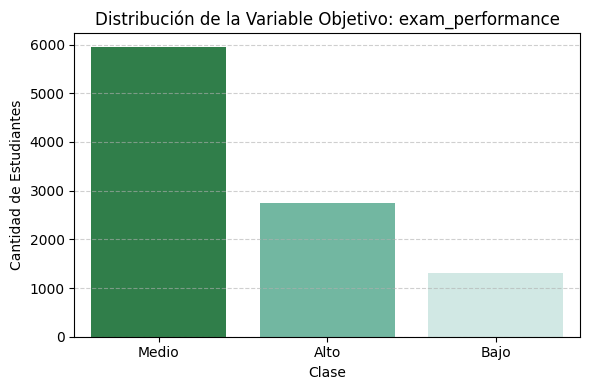

,Cantidad,Porcentaje (%)
exam_performance,,
Medio,5945,59.45
Alto,2740,27.40
Bajo,1315,13.15


In [192]:
# Conteo de clases
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="exam_performance",palette="BuGn_r")
plt.title("Distribución de la Variable Objetivo: exam_performance")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Estudiantes")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Tabla con conteo y porcentaje
target_counts = df["exam_performance"].value_counts()
target_percent = round(df["exam_performance"].value_counts(normalize=True) * 100, 2)

summary_df = pd.DataFrame({
    "Cantidad": target_counts,
    "Porcentaje (%)": target_percent
})

summary_df.style.set_caption(" Distribución de Clases en 'exam_performance'")\
    .background_gradient(cmap='BuGn')\
    .format(precision=2)


 **Análisis**

La variable `exam_performance` muestra una distribución bastante desbalanceada, con una mayoría de estudiantes en la categoría "Medio", seguida por "Alto" y bastante más atrás "Bajo", que representa solo el 13% de los casos.

Si bien el desbalance es evidente, no es tan extremo como para que sea necesario aplicar técnicas de rebalanceo desde el arranque. Vamos a poder entrenar modelos igual y ver qué tan bien se desempeñan, sobre todo en la clase minoritaria.

En caso de que los modelos tengan problemas para predecir correctamente la clase "Bajo", ahí sí se puede pensar en ajustar el enfoque, ya sea con métricas como f1-score o aplicando algo como SMOTE para balancear un poco mejor.


### 4.3 Visualización de distribuciones de variables


#### 🟢Clasificacion


Se analizan las distribuciones de las variables predictoras numéricas mediante histogramas, con el fin de identificar sesgos, asimetrías y posibles valores atípicos. Estas visualizaciones también ayudan a comprender cómo están distribuidos los datos que alimentarán los modelos de clasificación.

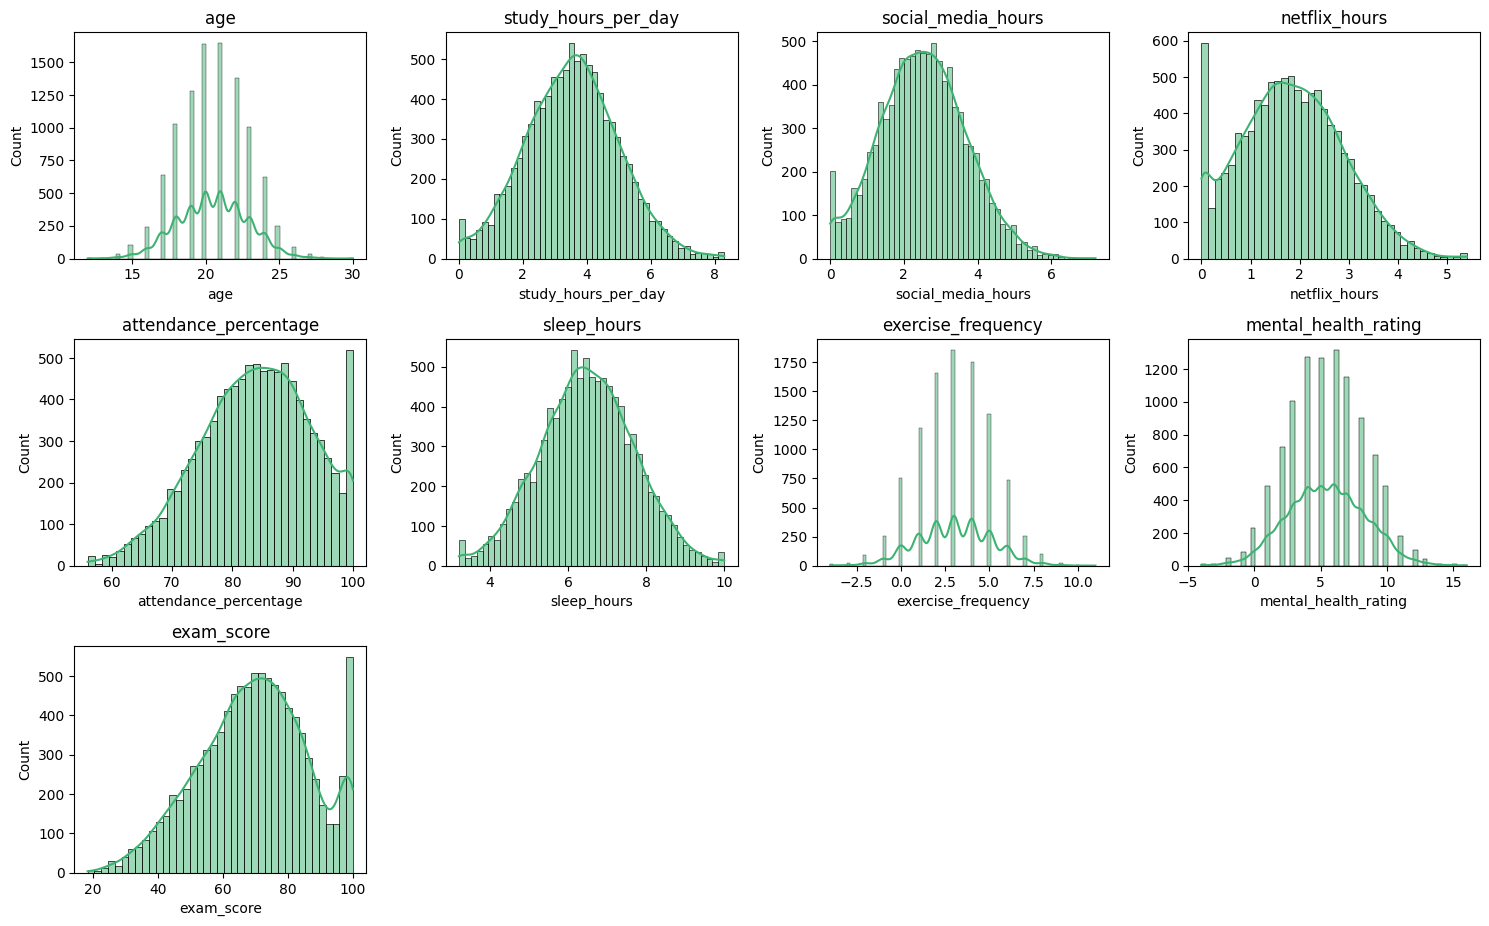

In [193]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

# Histograma de todas las variables numéricas
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data=df, x=col, kde=True, color="mediumseagreen")
    plt.title(col)
    plt.tight_layout()

 **Análisis de distribuciones**  
Se muestran las distribuciones de las variables numéricas que serán usadas para predecir `exam_performance`. Se destacan los siguientes aspectos:

- **Variables como `age` y `sleep_hours`** están distribuidas de forma razonablemente simétrica, lo que puede facilitar su uso en modelos lineales o árboles.
- **Asimetría**: Se observa una clara asimetría positiva en variables como `social_media_hours`, `netflix_hours` y `study_hours_per_day`, donde la mayoría de los valores se concentran en los rangos bajos y hay una cola larga hacia la derecha. Este tipo de distribución puede influir en el desempeño de ciertos modelos (como regresión lineal o SVM), por lo que puede ser útil considerar técnicas como normalización o transformaciones logarítmicas si fuera necesario.
- La variable `exercise_frequency` muestra una distribución claramente discreta, con valores puntuales que probablemente correspondan a días o frecuencias enteras de actividad física. Esto se va a tener en cuenta al momento de codificar o tratar esta variable.
- Estas distribuciones nos dan un buen punto de partida para ver si existen diferencias marcadas entre los niveles de rendimiento (Bajo, Medio, Alto) en función de las distintas variables. Más adelante vamos a complementar esto con boxplots por clase para observar esas relaciones de forma más clara.

El análisis exploratorio muestra que las variables tienen comportamientos bastante distintos entre sí, por lo que va a ser importante preprocesarlas bien antes de pasar a los modelos de clasificación.

#### 🔵Regresion

Aunque ya se analizaron estas variables numéricas en la etapa exploratoria, volvemos a graficarlas ahora con foco en el modelo de regresión. El objetivo es reevaluar su distribución y comportamiento, pero esta vez considerando cómo podrían influir directamente en la predicción de `exam_score`.

Para la parte de regresión, se hace una exploración visual de las variables numéricas usando histogramas con curva de densidad. Esto nos sirve para ver si hay sesgos, asimetrías o valores extremos que podrían influir en el rendimiento del modelo más adelante.

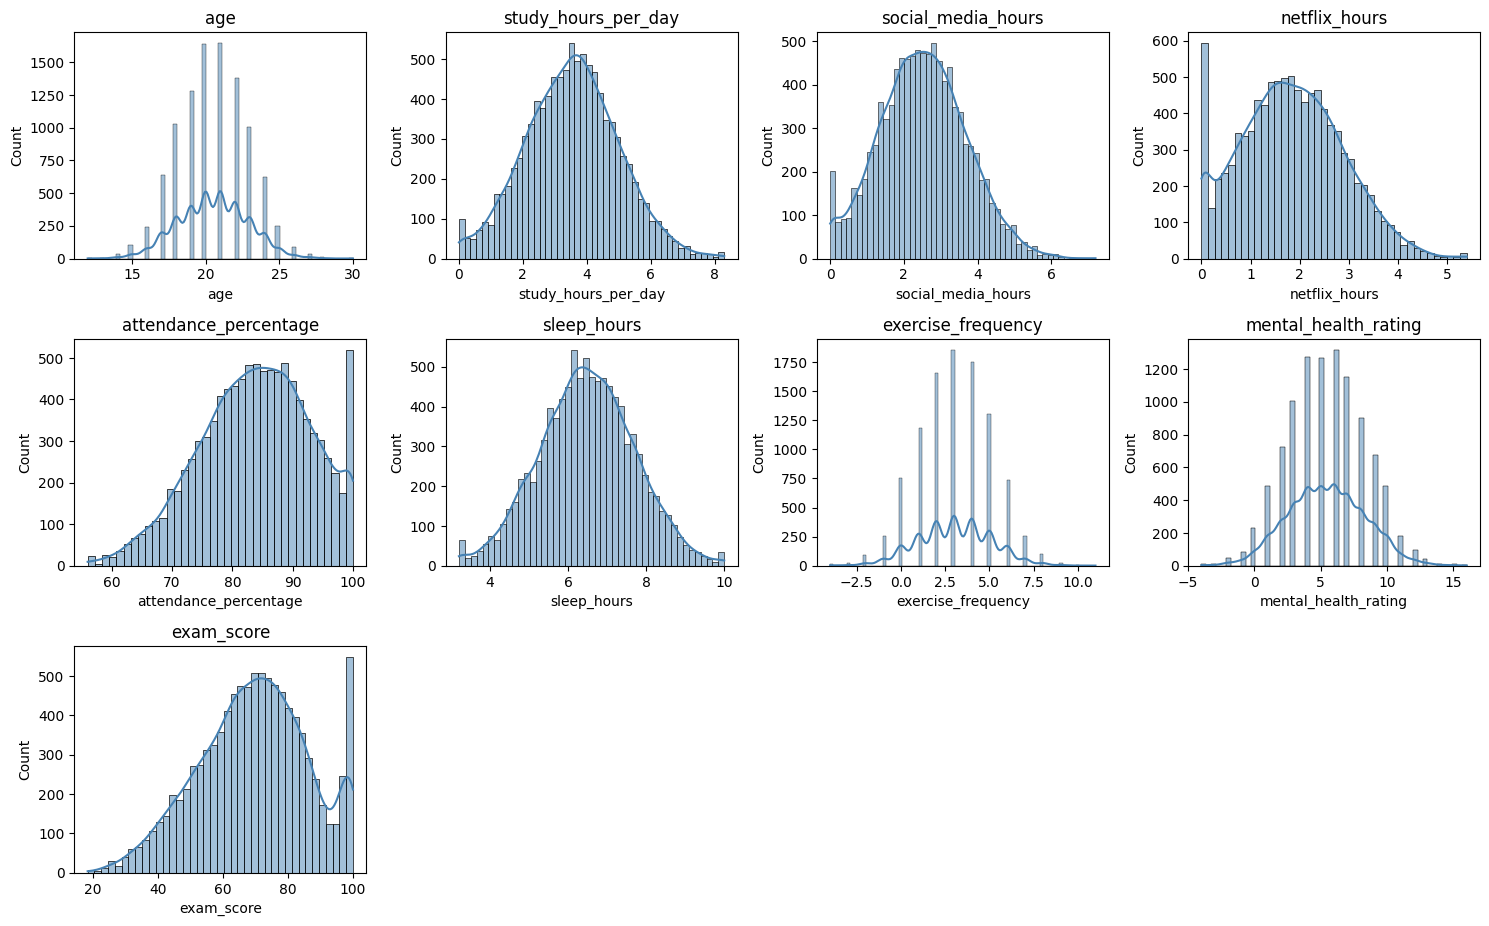

In [194]:
# Selección de columnas numéricas
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

# Histograma para cada variable numérica
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True, color="steelblue")
    plt.title(col)
    plt.tight_layout()

**Análisis de distribuciones para regresión**
Aunque estas variables numéricas ya fueron exploradas previamente, en este caso retomamos su análisis con foco en el modelo de regresión, evaluando su impacto potencial en la predicción de `exam_score`.

Distribución normal o casi simétrica: variables como `age`, `sleep_hours` y `mental_health_rating` tienen distribuciones relativamente estables, lo cual favorece su uso directo en modelos lineales.

Asimetría positiva (sesgo a la derecha): `study_hours_per_day`, `social_media_hours` y `netflix_hours` muestran sesgos, con la mayoría de los valores en rangos bajos y colas largas hacia valores altos. Esto podría requerir transformaciones si afecta el ajuste del modelo.

`exercise_frequency` mantiene su comportamiento discreto y podría tratarse como variable ordinal, o bien normalizarse si se la incluye como numérica.

La variable `exam_score`, que es nuestro target en la regresión, muestra una leve asimetría negativa con muchos valores entre 70 y 80, y un pico en 100 que podría deberse a un límite superior forzado (por ejemplo, nota máxima). Este comportamiento debe tenerse en cuenta a la hora de evaluar el error del modelo.

### 4.4 Detección de valores atípicos


Se utilizan boxplots para detectar posibles valores atípicos en las variables numéricas. Estas observaciones extremas pueden afectar el rendimiento de ciertos modelos, especialmente aquellos sensibles a la escala y distribución como la regresión logística o KNN.

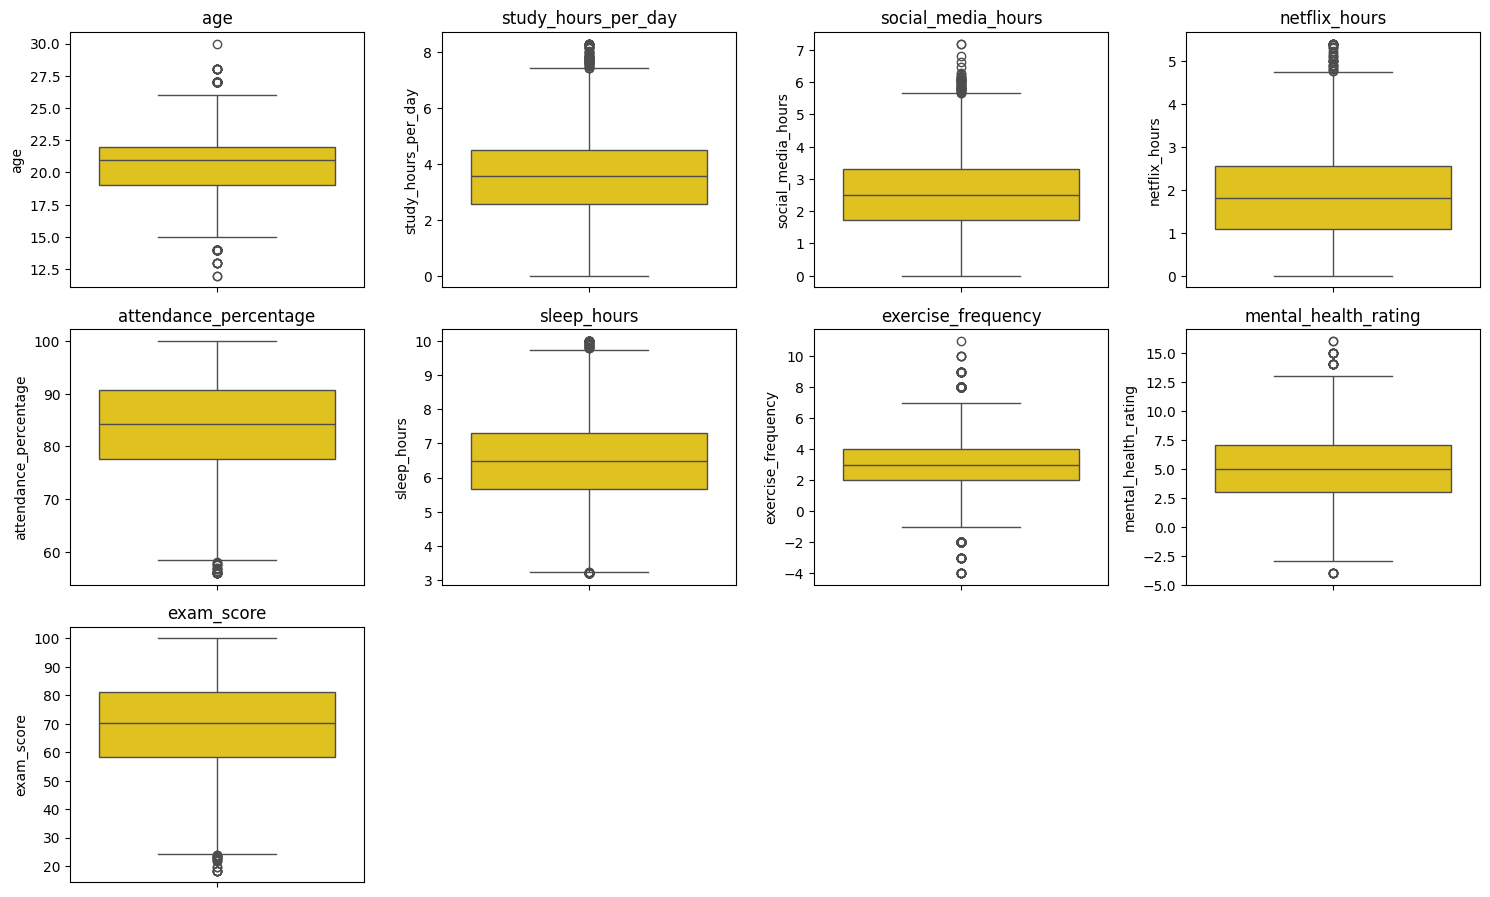

In [195]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=df, y=col, color="gold")
    plt.title(col)
    plt.tight_layout()

### Consideración de Outliers
Durante el análisis exploratorio se identificaron algunos posibles outliers en varias variables numéricas. Por el momento, decidimos conservarlos para poder evaluar su impacto real en el rendimiento de los modelos

### 4.5 Correlación entre variables



Se utiliza una matriz de correlación para identificar relaciones entre las variables numéricas del dataset. Esto permite detectar redundancias o dependencias que pueden afectar el rendimiento del modelo y ayudan a reducir la dimensionalidad si es necesario.

C:\Users\lautaro.iriart\AppData\Local\Temp\ipykernel_1952\622399013.py:6: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\lautaro.iriart\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


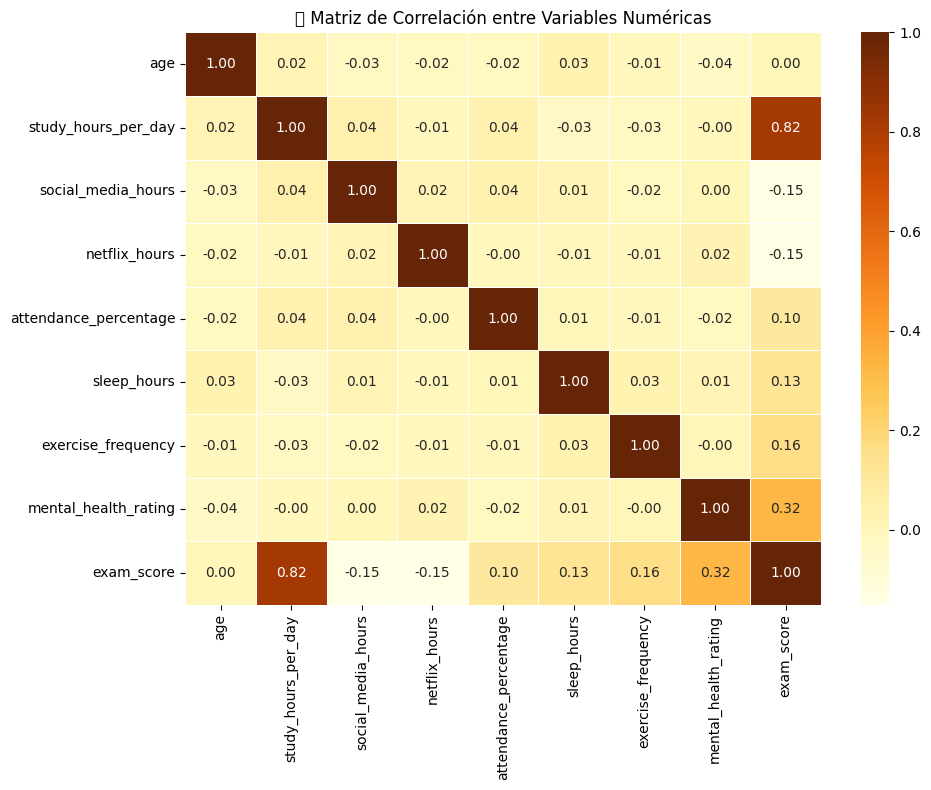

In [196]:
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=["float64", "int64"]).corr()

sns.heatmap(corr, annot=True, cmap="YlOrBr", fmt=".2f", linewidths=0.5)
plt.title("🔗 Matriz de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

 **Análisis de Correlación**

La matriz de correlación muestra cómo se relacionan las variables numéricas con `exam_score`, que es la variable que queremos predecir en el modelo de regresión.

La que más se destaca es `study_hours_per_day`, con una correlación bastante alta (0.82), lo cual es lógico: cuanto más estudian, mejor les va. Después aparece `mental_health_rating`, que también tiene una relación positiva (0.32), así que podría tener cierto peso.

Otras variables como `exercise_frequency`, `sleep_hours` y `attendance_percentage` tienen correlaciones más bajas pero positivas. Capaz no pesan tanto, pero igual pueden sumar algo al modelo.

En cambio, `social_media_hours` y `netflix_hours` tienen correlación negativa con el rendimiento, aunque no es muy fuerte. Y `age`, por ejemplo, directamente no aporta nada en términos de correlación.

Este análisis nos da una primera idea de qué variables podrían influir más en el rendimiento, pero igual después hay que ver qué tanto pesan en los modelos cuando los entrenemos.

### 4.6 – Visualización de la Matriz de Dispersión por Clase

#### 🟢Clasificacion

Esta visualización permite observar la relación entre variables numéricas según las clases de la variable objetivo `exam_performance`. Es útil para detectar patrones, agrupaciones o separaciones que podrían ser captadas por modelos de clasificación.

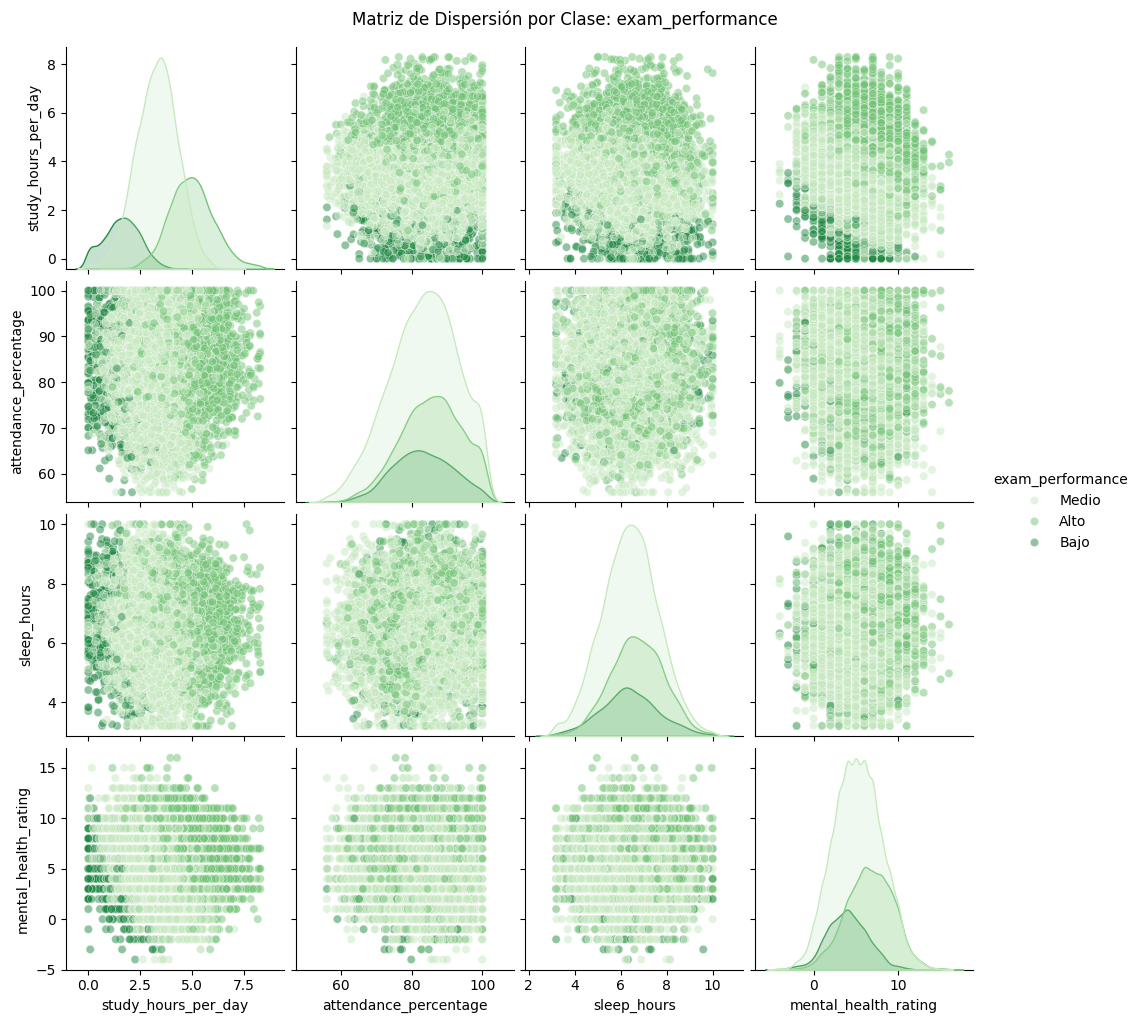

In [197]:
# Matriz de dispersión por clase
sns.pairplot(df,
             vars=["study_hours_per_day", "attendance_percentage", "sleep_hours", "mental_health_rating"],
             hue="exam_performance",
             palette="Greens",  # verde para clasificación
             diag_kind="kde",
             plot_kws={'alpha': 0.5})
plt.suptitle("Matriz de Dispersión por Clase: exam_performance", y=1.02)
plt.show()

 **Análisis**

La matriz de dispersión permite ver cómo se distribuyen las clases de rendimiento (`exam_performance`) en relación a algunas variables numéricas.

Se nota que los estudiantes con rendimiento alto tienden a concentrarse en valores más altos de `study_hours_per_day` y `attendance_percentage`, lo que refuerza lo que vimos en la correlación.

También hay una leve tendencia a que quienes duermen más y reportan mejor salud mental tengan mejores resultados, aunque en estos casos las diferencias entre clases no son tan marcadas.



#### 🔵Regresion

Para examinar visualmente cómo se relacionan las distintas variables numéricas con la variable objetivo exam_score, se construyó una matriz de dispersión. Esta herramienta permite identificar patrones de asociación, posibles relaciones lineales o no lineales, y detectar valores atípicos que puedan influir en el modelo de regresión.

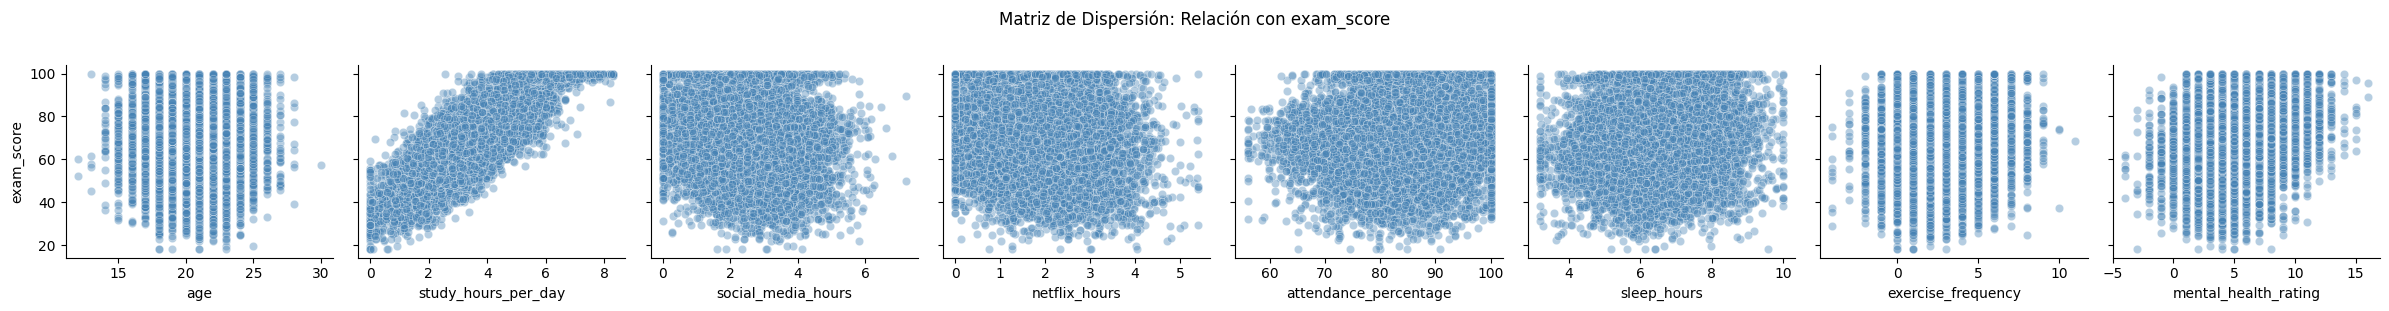

In [198]:
# Selección de variables numéricas
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
num_cols.remove("exam_score")  # exam_score se coloca como target en y

# Crear pairplot para examinar relación con exam_score
sns.pairplot(df, x_vars=num_cols, y_vars=["exam_score"], height=3, aspect=1, kind="scatter",
             plot_kws={"alpha":0.4, "color":"steelblue"})
plt.suptitle("Matriz de Dispersión: Relación con exam_score", y=1.02)
plt.tight_layout()
plt.show()

En estos gráficos se puede ver bastante claro que `study_hours_per_day` tiene una relación positiva fuerte con el puntaje del examen: **a más horas de estudio, mejores resultados**. Lo mismo (aunque en menor medida) pasa con `mental_health_rating`, lo que podría estar mostrando que el bienestar emocional también influye en el rendimiento.

Estos patrones coinciden con lo que ya se había visto en la matriz de correlación, así que refuerzan la idea de que estas variables van a tener bastante peso en el modelo.

En cambio, variables como `social_media_hours` o `netflix_hours` no muestran una relación tan clara. Hay cierta tendencia inversa, pero los datos están bastante dispersos, así que no parece algo lineal ni directo.

Estas observaciones ayudan a tener una idea de qué variables podrían sumar más al modelo de regresión que vamos a entrenar después.

### 4.7 Boxplots por clase de rendimiento académico 🟢Clasificacion

#### Verificación Estadística: Prueba ANOVA antes del análisis visual


Antes de visualizar las variables numéricas por clase de rendimiento, se realiza una prueba ANOVA para verificar si existen diferencias estadísticamente significativas entre las medias de los grupos (Bajo, Medio y Alto rendimiento).

In [199]:
# Seleccionar variables numéricas
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Lista para almacenar resultados
anova_results = []

# Aplicar ANOVA para cada variable numérica
for col in numeric_cols:
    try:
        grupos = [grupo[col] for _, grupo in df.groupby("exam_performance")]
        f_stat, p_val = f_oneway(*grupos)
        anova_results.append({"Variable": col, "Valor p": p_val})
    except:
        anova_results.append({"Variable": col, "Valor p": None})

# Convertir en DataFrame y ordenar
anova_df = pd.DataFrame(anova_results).sort_values("Valor p").reset_index(drop=True)

# Mostrar tabla ordenada
display(anova_df)

,Variable,Valor p
0,study_hours_per_day,0.000000e+00
1,exam_score,0.000000e+00
2,mental_health_rating,1.234572e-186
3,social_media_hours,2.455281e-49
4,netflix_hours,4.873559e-44
5,exercise_frequency,1.571412e-43
6,sleep_hours,2.188873e-28
7,attendance_percentage,1.380836e-24
8,age,1.400335e-02


**Interpretación de los resultados de la prueba ANOVA por variable**

La prueba ANOVA confirmó que la mayoría de las variables numéricas tienen diferencias estadísticamente significativas entre los grupos de rendimiento (`exam_performance`). Algunas, como `study_hours_per_day` y `mental_health_rating`, mostraron valores p bajísimos, lo que refuerza lo que ya se venía viendo en la exploración previa.

En el caso de `exam_score`, era esperable que el valor p dé cero porque justamente se usó para construir la variable de rendimiento, así que no lo vamos a considerar para análisis visual.

Variables como `social_media_hours`, `netflix_hours`, `exercise_frequency` y `sleep_hours` también mostraron diferencias claras entre los grupos, aunque su interpretación puede depender de otros factores más complejos (como el contexto o el estilo de vida).

La única que quedó medio floja fue `age`, que si bien dio significativa, tiene un valor p mucho más alto que el resto. No parece tener tanto peso en la diferencia entre grupos.

**Selección de variables para los boxplots**

Luego de aplicar ANOVA, se seleccionaron las siguientes variables para representarlas gráficamente mediante boxplots, debido a su alta significancia estadística y relevancia interpretativa en el contexto académico:

- `study_hours_per_day`  
- `sleep_hours`  
- `attendance_percentage`

Estas variables permiten analizar cómo varían los hábitos y comportamientos más directamente relacionados con el rendimiento académico entre los distintos grupos definidos por `exam_performance`. Su inclusión en los gráficos está justificada por los resultados estadísticos obtenidos, lo que garantiza un análisis riguroso y fundamentado.

#### Representación gráfica de variables significativas mediante boxplots



A continuación se presentan gráficos tipo boxplot que muestran cómo varían las variables seleccionadas según la clase de rendimiento académico (`exam_performance`). Estas variables fueron elegidas luego de aplicar la prueba ANOVA, que confirmó que existen diferencias estadísticamente significativas entre los grupos Bajo, Medio y Alto.

Los gráficos permiten observar visualmente la dispersión, la mediana y posibles valores atípicos en cada grupo.

C:\Users\lautaro.iriart\AppData\Local\Temp\ipykernel_1952\1043910122.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], data=df, x="exam_performance", y="study_hours_per_day", palette="YlOrBr")
C:\Users\lautaro.iriart\AppData\Local\Temp\ipykernel_1952\1043910122.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df, x="exam_performance", y="sleep_hours", palette="YlOrBr")
C:\Users\lautaro.iriart\AppData\Local\Temp\ipykernel_1952\1043910122.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2], data=d

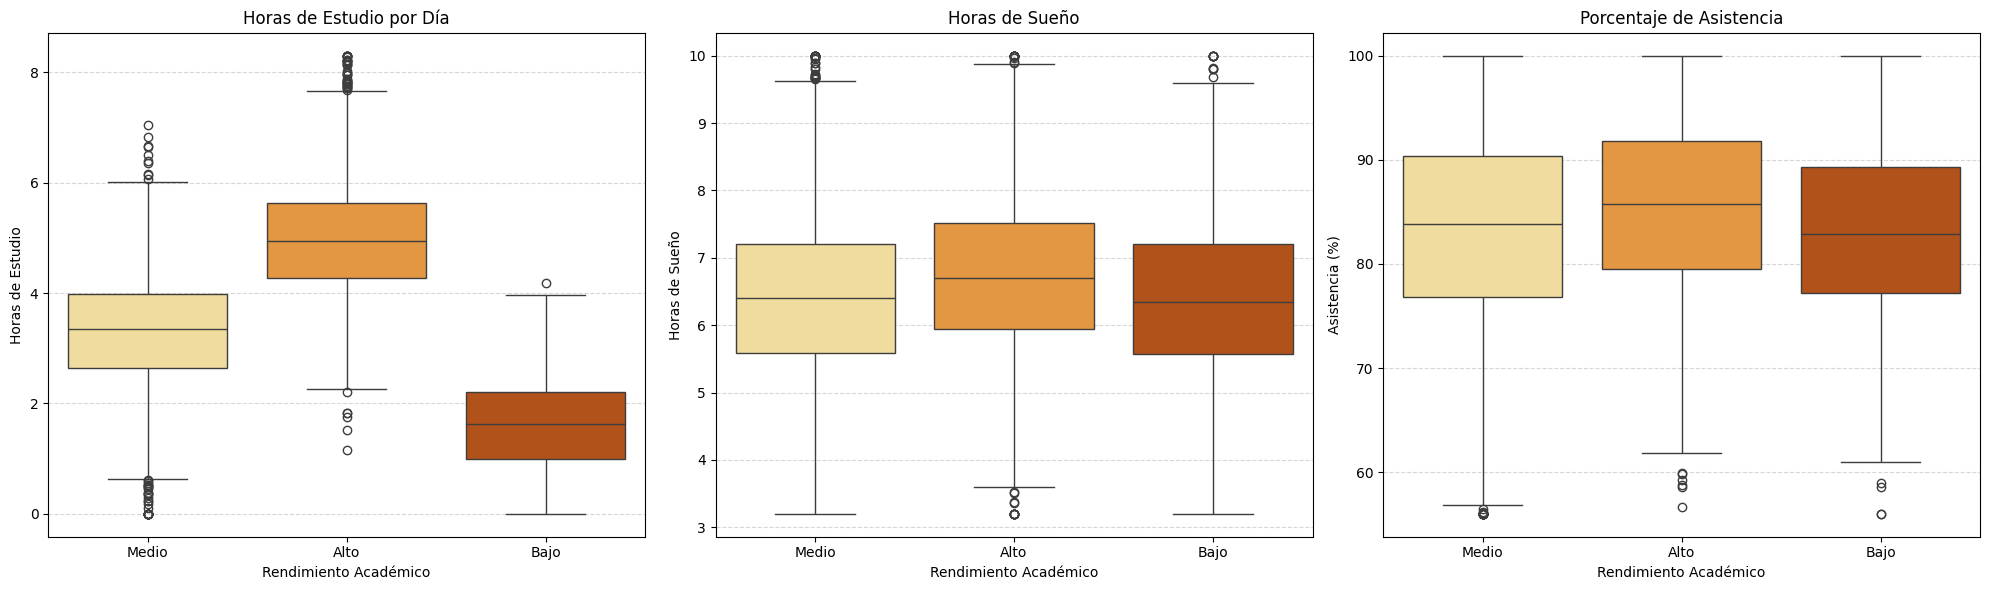

In [200]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

# Boxplot 1: Horas de estudio por día
sns.boxplot(ax=axes[0], data=df, x="exam_performance", y="study_hours_per_day", palette="YlOrBr")
axes[0].set_title("Horas de Estudio por Día")
axes[0].set_xlabel("Rendimiento Académico")
axes[0].set_ylabel("Horas de Estudio")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Boxplot 2: Horas de sueño
sns.boxplot(ax=axes[1], data=df, x="exam_performance", y="sleep_hours", palette="YlOrBr")
axes[1].set_title("Horas de Sueño")
axes[1].set_xlabel("Rendimiento Académico")
axes[1].set_ylabel("Horas de Sueño")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Boxplot 3: Porcentaje de asistencia
sns.boxplot(ax=axes[2], data=df, x="exam_performance", y="attendance_percentage", palette="YlOrBr")
axes[2].set_title("Porcentaje de Asistencia")
axes[2].set_xlabel("Rendimiento Académico")
axes[2].set_ylabel("Asistencia (%)")
axes[2].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


A partir de los boxplots presentados, se observan los siguientes patrones en relación con el rendimiento académico (`exam_performance`):

- **Horas de estudio por día:** Acá la diferencia es muy clara. Los estudiantes con rendimiento alto estudian más horas en promedio, y tienen una distribución mucho más concentrada en valores altos. En cambio, los de rendimiento bajo tienden a estudiar menos, con muchos casos por debajo de 2 horas por día. Es consistente con la idea de que mayor dedicación al estudio suele ir de la mano con mejores resultados.

- **Horas de sueño:** Las diferencias no son tan evidentes como en el caso anterior, pero se nota que los estudiantes con mejor rendimiento suelen tener una rutina de sueño un poco más estable y centrada. Hay menos dispersión en ese grupo, mientras que en los otros dos hay más valores extremos, sobre todo hacia abajo.

- **Porcentaje de asistencia:** También se ve cierta diferencia, aunque más sutil. Los estudiantes de alto rendimiento tienen una mediana de asistencia levemente más alta, lo que refuerza la idea de que ir a clase ayuda, aunque no es tan determinante como las horas de estudio.

Estos gráficos respaldan visualmente los resultados obtenidos en la prueba ANOVA, confirmando que las variables seleccionadas presentan diferencias significativas entre los niveles de rendimiento académico. Por tanto, son variables clave para incluir en etapas posteriores del análisis predictivo.

### 4.8 Exploración y Selección de Características (Feature Selection)🟢Clasificacion




Se realizó un análisis estadístico de las variables numéricas para identificar cuáles presentan una mayor relación con la variable objetivo `exam_performance`. Para ello se utilizó la técnica de **SelectKBest** con el test ANOVA (`f_classif`), que permite evaluar la relevancia de cada predictor de forma individual.

Esto no solo permitió conocer la importancia de cada variable, sino también establecer una primera **selección de características relevantes** para los modelos de clasificación que se desarrollarán más adelante.

In [201]:
# Separar variables predictoras numéricas y variable objetivo
X_num = df.select_dtypes(include='number').drop(columns=["exam_score"])  # quitamos exam_score porque se usó para crear exam_performance
y = df["exam_performance"]

# Aplicar SelectKBest
selector = SelectKBest(score_func=f_classif, k='all')  # analizamos todas para ver sus puntajes
selector.fit(X_num, y)

# Resultados en DataFrame
feature_scores = pd.DataFrame({
    "Variable": X_num.columns,
    "Puntaje F (f_classif)": selector.scores_,
    "Valor p": selector.pvalues_
}).sort_values("Puntaje F (f_classif)", ascending=False).reset_index(drop=True)

# Visualización
feature_scores.style.set_caption("Resultados de la Selección de Características (SelectKBest con f_classif)")\
    .background_gradient(cmap='BuGn')\
    .format({"Puntaje F (f_classif)": "{:.2f}", "Valor p": "{:.4f}"})

,Variable,Puntaje F (f_classif),Valor p
0,study_hours_per_day,5479.80,0.0000
1,mental_health_rating,446.93,0.0000
2,social_media_hours,113.19,0.0000
3,netflix_hours,100.73,0.0000
4,exercise_frequency,99.54,0.0000
5,sleep_hours,64.10,0.0000
6,attendance_percentage,55.24,0.0000
7,age,4.27,0.0140


**Conclusión**

La técnica `SelectKBest` con el método `f_classif` permitió identificar qué variables numéricas tienen mayor relación con el rendimiento académico (`exam_performance`). Las variables más destacadas fueron `study_hours_per_day`, `mental_health_rating` y `social_media_hours`, ya que obtuvieron los puntajes más altos y valores p muy bajos, lo que indica que son estadísticamente relevantes.

Aunque algunas variables como `sleep_hours` y `attendance_percentage` no aparecen entre las primeras, también mostraron una relación significativa. La variable `age`, en cambio, tuvo una influencia menor.

Es importante notar que las variables seleccionadas en este análisis no coinciden exactamente con las elegidas en el análisis visual con boxplots. Esto se debe a que ambas técnicas tienen enfoques diferentes: una se basa en visualización y la otra en evaluación estadística. Usar ambas estrategias permite tener una visión más completa para decidir qué variables incluir en los modelos.

*Este análisis será retomado en la fase de modelado para evaluar el rendimiento de los modelos con y sin reducción de dimensiones.*

### 4.9 Reducción de Dimensiones (PCA) 🟢Clasificacion



Ahora aplicamos PCA (Análisis de Componentes Principales) para reducir un poco la cantidad de variables numéricas y ver cómo se distribuyen los datos en un espacio más compacto. La idea no es mejorar la clasificación directamente, sino más bien explorar si las clases de `exam_performance` se separan de forma más o menos natural cuando bajamos la dimensionalidad.

Esto también sirve para detectar si hay variables que están diciendo más o menos lo mismo (redundancia) o si hay algún patrón general que no habíamos visto antes.

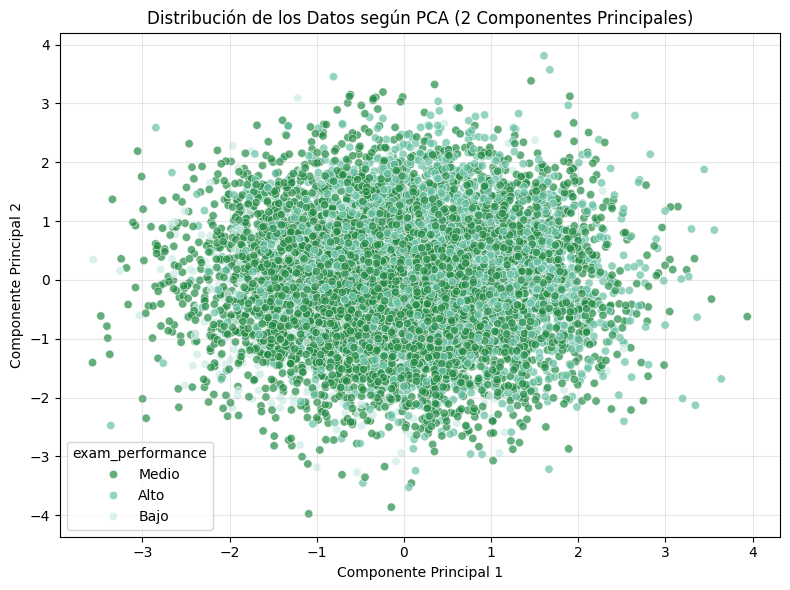

In [202]:
# Seleccionar variables numéricas (sin exam_score)
X_pca = df.select_dtypes(include='number').drop(columns=["exam_score"])

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Aplicar PCA
pca = PCA(n_components=2)  # Reducimos a 2 componentes principales
X_pca_2D = pca.fit_transform(X_scaled)

# Crear DataFrame para graficar
pca_df = pd.DataFrame(X_pca_2D, columns=["PC1", "PC2"])
pca_df["exam_performance"] = df["exam_performance"].values

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="exam_performance", palette="BuGn_r", alpha=0.7)
plt.title("Distribución de los Datos según PCA (2 Componentes Principales)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Conclusión PCA**

Después de aplicar PCA y reducir todas las variables numéricas a dos componentes, el gráfico nos permite ver cómo se distribuyen los datos en un plano más simple. La idea era ver si los grupos de rendimiento académico (**Bajo**, **Medio**, **Alto**) se separaban de forma más o menos natural en ese espacio reducido.

La realidad es que no. Las clases aparecen bastante mezcladas entre sí, sin una estructura clara que las distinga. No hay grupos definidos ni patrones evidentes que permitan diferenciarlos visualmente en este plano.

Pero eso no significa que no se puedan clasificar bien. Lo que nos dice este gráfico es que la separación entre clases probablemente dependa de relaciones más complejas entre las variables, que no se reflejan en los primeros dos componentes. Así que va a ser tarea de los modelos de clasificación encontrar esos patrones más sutiles.

## 5. Modelos



Antes de avanzar con la construcción y evaluación de los modelos (tanto de clasificación como de regresión), es necesario dejar el dataset bien preparado. En esta etapa se van a realizar los siguientes pasos:

- Normalización de las variables numéricas cuando sea necesario.

- División del dataset en conjuntos de entrenamiento y prueba.

- Codificación de variables categóricas para que puedan ser interpretadas por los modelos.

Estos pasos son clave para asegurar que los modelos trabajen con datos consistentes y comparables, y para minimizar posibles sesgos o errores en el entrenamiento.

### 🟢Clasificacion

#### 5.1 División del dataset en entrenamiento y prueba

In [203]:
# Definimos X e y
X = df[["study_hours_per_day", "mental_health_rating", "social_media_hours"]]
y = df["exam_performance"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Visualizamos las dimensiones resultantes
print("Tamaño del set de entrenamiento:", X_train.shape)
print("Tamaño del set de prueba:", X_test.shape)

Tamaño del set de entrenamiento: (7000, 3)
Tamaño del set de prueba: (3000, 3)


#### 5.2 Transformación de Datos



Aunque la mayoría de las variables numéricas ya venían en escalas razonables, hay modelos como la Regresión Logística que son bastante sensibles a las diferencias de magnitud. Por eso, en esta parte se decide normalizar solo las variables que realmente lo necesitan, sin complicar de más el análisis pero asegurando que los modelos trabajen con datos comparables.

- Codificación de la variable objetivo: La variable `exam_performance`, que contenía valores categóricos ("Bajo", "Medio" y "Alto"), fue transformada a valores numéricos (0, 1, 2) mediante **Label Encoding**. Esta conversión permite que los modelos de clasificación puedan procesarla correctamente. No se codificaron las variables predictoras ya que, en este caso, todas son numéricas.

- Estandarización de variables numéricas: Se aplicó **StandardScaler** a variables como `study_hours_per_day`, `mental_health_rating` y `social_media_hours`, para llevarlas a una escala común con media 0 y desviación estándar 1. Esto es especialmente útil en algoritmos sensibles a la escala de los datos.

**`Nota:`** Ambas transformaciones se ajustaron utilizando únicamente el conjunto de entrenamiento (fit) y luego se aplicaron al conjunto de prueba (transform), evitando así cualquier tipo de filtración de información.

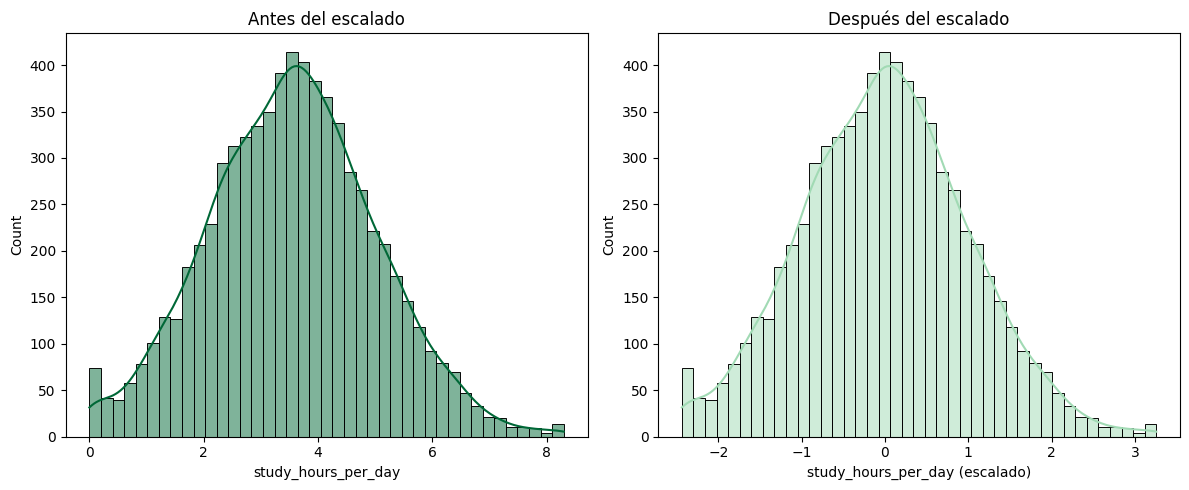

In [204]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # Ajustar y transformar solo con el set de entrenamiento
y_test_enc = le.transform(y_test)         # Transformar test con el encoder ya entrenado


# Estandarización de variables numéricas (StandardScaler)

scaler = StandardScaler()

# Ajustar solo con datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Visualización antes y después del escalado


# Colores de la paleta BuGn_r ya utilizados en el trabajo
color_antes = '#006837'   # Verde más oscuro
color_despues = '#a1dab4' # Verde agua muy claro

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma antes del escalado
sns.histplot(X_train['study_hours_per_day'], kde=True, ax=axes[0], color=color_antes, edgecolor="black")
axes[0].set_title("Antes del escalado")
axes[0].set_xlabel("study_hours_per_day")

# Histograma después del escalado
study_idx = X_train.columns.get_loc('study_hours_per_day')  # forma más clara
sns.histplot(X_train_scaled[:, study_idx], kde=True, ax=axes[1], color=color_despues, edgecolor="black")
axes[1].set_title("Después del escalado")
axes[1].set_xlabel("study_hours_per_day (escalado)")

plt.tight_layout()
plt.show()

En el gráfico se puede observar cómo varía la distribución de la variable `study_hours_per_day` antes y después de aplicar el escalado.

- **Antes del escalado:** los valores se concentran alrededor de las 4 horas diarias, con una ligera asimetría hacia la derecha. Esta es la escala original en la que fue recolectado el dato.

- **Después del escalado:** la distribución se mantiene con la misma forma, pero los valores ahora están centrados en 0 y expresados en unidades de desviación estándar, gracias al uso de **StandardScaler**.

Este tipo de transformación es especialmente importante en modelos como la Regresión Logística, ya que evita que variables con diferentes escalas o unidades influyan desproporcionadamente en el entrenamiento. De esta forma, se mejora la estabilidad y el rendimiento general del modelo.

#### 5.3 Entrenamiento de los modelos

In [205]:
# Instanciar modelos
log_model = LogisticRegression(max_iter=1000)
tree_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar
log_model.fit(X_train, y_train_enc)
tree_model.fit(X_train, y_train_enc)
rf_model.fit(X_train, y_train_enc)

RandomForestClassifier(random_state=42)

### 🔵Regresion

#### 5.4 División del dataset en entrenamiento y prueba

In [206]:
# Definimos X e y
X2 = df[["study_hours_per_day", "mental_health_rating", "social_media_hours"]]
y2 = df["exam_score"]   # aquí tu variable continua

# División en entrenamiento y prueba
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2,
    test_size=0.3,
    random_state=42
)

# Visualizamos las dimensiones resultantes
print("Tamaño del set de entrenamiento:", X_train2.shape)
print("Tamaño del set de prueba:      ", X_test2.shape)


Tamaño del set de entrenamiento: (7000, 3)
Tamaño del set de prueba:       (3000, 3)


#### 5.5 Transformación de Datos

Aunque ya se había aplicado normalización en la parte de clasificación, en este caso se vuelve a realizar el proceso pero sobre las variables específicas que se van a usar en los modelos de regresión. Para mantener el análisis organizado y evitar cruces innecesarios entre variables y nombres, se usó una nueva versión de los conjuntos de entrenamiento y prueba (`X_train2`, `X_test2`).

Además, se vuelve a graficar la variable `study_hours_per_day` antes y después del escalado como referencia visual, y para confirmar que la transformación se mantuvo consistente.

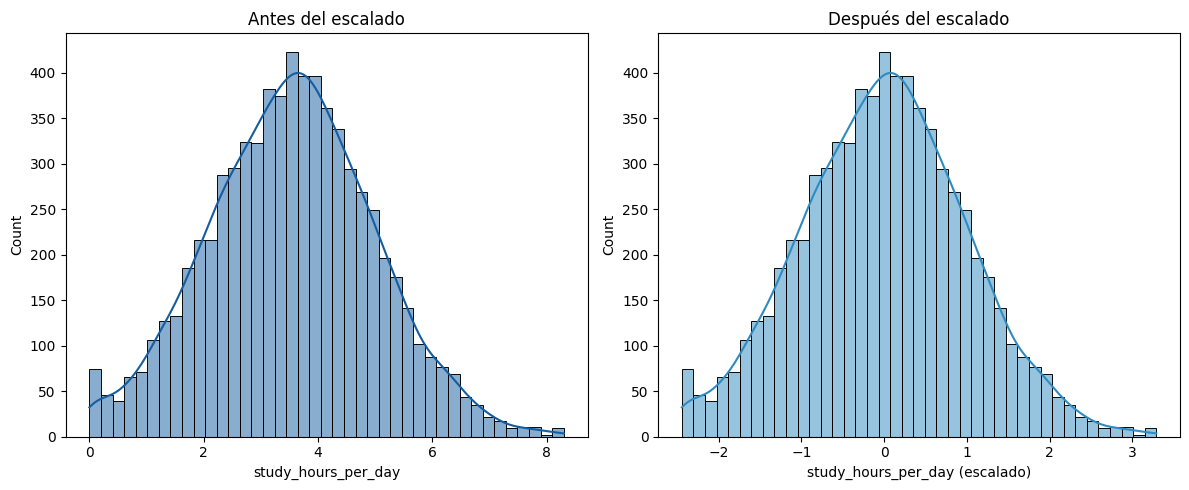

In [207]:
# Estandarización de variables numéricas
scaler = StandardScaler()

# Ajustar solo con X_train y luego transformar ambos
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2  = scaler.transform(X_test2)

# Visualización antes y después del escalado

# Colores de la paleta BuGn_r usados en clasificación
color_antes   = '#145da0'  # Azul más oscuro
color_despues = '#2e8bc0'  # Azul agua muy claro

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#   Histograma antes del escalado
sns.histplot(
    X_train2["study_hours_per_day"],
    kde=True,
    ax=axes[0],
    color=color_antes,
    edgecolor="black"
)
axes[0].set_title("Antes del escalado")
axes[0].set_xlabel("study_hours_per_day")
axes[0].set_ylabel("Count")

#   Histograma después del escalado
study_idx = X_train2.columns.get_loc("study_hours_per_day")
sns.histplot(
    X_train_scaled2[:, study_idx],
    kde=True,
    ax=axes[1],
    color=color_despues,
    edgecolor="black"
)
axes[1].set_title("Después del escalado")
axes[1].set_xlabel("study_hours_per_day (escalado)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

#### 5.6 Entrenamiento de los modelos

In [208]:

# Instanciar modelos
lr_model2 = LinearRegression()
dt_model2 = DecisionTreeRegressor(random_state=42)
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar
lr_model2.fit(X_train_scaled2, y_train2)
dt_model2.fit(X_train_scaled2, y_train2)
rf_model2.fit(X_train_scaled2, y_train2)


RandomForestRegressor(random_state=42)

## 6. Comparación de Modelos

### 🟢Clasificacion

#### 6.1 Evaluación y Comparación de modelos

In [209]:
# REGRESIÓN LOGÍSTICA
y_pred_log = log_model.predict(X_test)
print(" Resultados para Regresión Logística")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_log))
print("Matriz de Confusión:\n", confusion_matrix(y_test_enc, y_pred_log))
print("Reporte de Clasificación:\n", classification_report(y_test_enc, y_pred_log))

# ÁRBOL DE DECISIÓN
y_pred_tree = tree_model.predict(X_test)
print("\n Resultados para Árbol de Decisión")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_tree))
print("Matriz de Confusión:\n", confusion_matrix(y_test_enc, y_pred_tree))
print("Reporte de Clasificación:\n", classification_report(y_test_enc, y_pred_tree))

# RANDOM FOREST
y_pred_rf = rf_model.predict(X_test)
print("\n Resultados para Random Forest")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test_enc, y_pred_rf))
print("Reporte de Clasificación:\n", classification_report(y_test_enc, y_pred_rf))

# --------------------------------------------
# TABLA COMPARATIVA ESTILIZADA (Colores según rendimiento)
# --------------------------------------------

# Crear DataFrame con resultados
resultados = pd.DataFrame({
    "Modelo": ["Random Forest", "Regresión Logística", "Árbol de Decisión"],
    "Accuracy": [0.826, 0.808, 0.734],
    "Macro F1-Score": [0.79, 0.77, 0.75],
    "Weighted F1-Score": [0.83, 0.81, 0.79]
})

# Colores ordenados según rendimiento (más oscuro = mejor modelo)
colores = ["#69B486", "#A7D6A9", "#D7ECE4"]  # oscuro, medio, claro

def color_filas(row):
    color = colores[row.name]
    return [f'background-color: {color}; color: black'] * len(row)

# Mostrar tabla con estilo
resultados.style\
    .apply(color_filas, axis=1)\
    .format({"Accuracy": "{:.3f}", "Macro F1-Score": "{:.2f}", "Weighted F1-Score": "{:.2f}"})\
    .set_caption("Resumen Comparativo de Modelos de Clasificación")


 Resultados para Regresión Logística
Accuracy: 0.808
Matriz de Confusión:
 [[ 603    0  219]
 [   0  259  136]
 [ 142   79 1562]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77       822
           1       0.77      0.66      0.71       395
           2       0.81      0.88      0.84      1783

    accuracy                           0.81      3000
   macro avg       0.80      0.76      0.77      3000
weighted avg       0.81      0.81      0.81      3000


 Resultados para Árbol de Decisión
Accuracy: 0.734
Matriz de Confusión:
 [[ 568    0  254]
 [   1  259  135]
 [ 247  161 1375]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69       822
           1       0.62      0.66      0.64       395
           2       0.78      0.77      0.78      1783

    accuracy                           0.73      3000
   macro avg       0.70      0.71 

,Modelo,Accuracy,Macro F1-Score,Weighted F1-Score
0,Random Forest,0.826,0.79,0.83
1,Regresión Logística,0.808,0.77,0.81
2,Árbol de Decisión,0.734,0.75,0.79


**Conclusión del Análisis de Modelos de Clasificación**
Después de comparar los tres modelos, se puede decir que Random Forest fue el que mejor rendimiento tuvo en general. Logró un accuracy del **82.6%** y un F1 ponderado de **0.83**, lo que lo convierte en la mejor opción para predecir el nivel de rendimiento académico.

La Regresión Logística también anduvo muy bien (**80.8% de accuracy**), así que sigue siendo una alternativa válida, sobre todo si se busca un modelo más simple y fácil de interpretar.

El Árbol de Decisión, si bien es útil para entender reglas o relaciones entre variables, quedó atrás en todas las métricas.

Con estos resultados, todo indica que Random Forest es el modelo más robusto para este problema, y es el que se elige para seguir con el análisis o para aplicarlo en un contexto real.

C:\Users\lautaro.iriart\AppData\Local\Temp\ipykernel_1952\3368161054.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Variable", data=importancia_df, palette="YlGn")


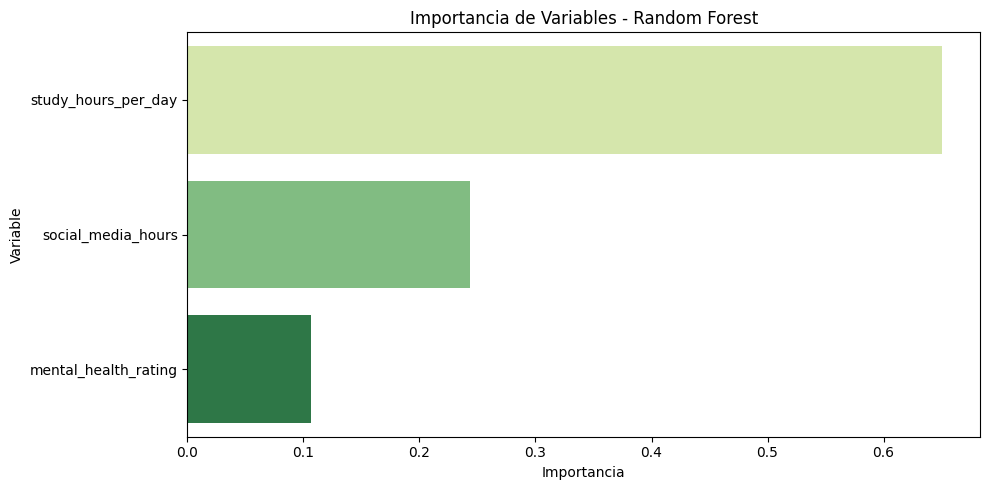

In [210]:
# Obtener importancia de cada variable
importancia = rf_model.feature_importances_

# Crear DataFrame
importancia_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia
}).sort_values(by="Importancia", ascending=False)

# Graficar
plt.figure(figsize=(10, 5))
sns.barplot(x="Importancia", y="Variable", data=importancia_df, palette="YlGn")
plt.title("Importancia de Variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

El gráfico muestra qué tanto aportó cada variable a las decisiones del modelo de **Random Forest**. Como se ve, `study_hours_per_day` fue por lejos la más importante: tiene mucho peso a la hora de predecir el rendimiento académico, lo cual es consistente con todo lo que se vio en el análisis anterior.

Después aparece `social_media_hours`, que también tiene cierta influencia, posiblemente relacionada con el tiempo que se le saca al estudio o al descanso. Por último, `mental_health_rating` aportó algo menos, pero sigue teniendo un rol en la predicción.

Este análisis ayuda a entender qué variables están teniendo más peso en las predicciones, y confirma que ciertos hábitos realmente marcan la diferencia en el rendimiento académico.

#### 6.2 Evaluación con y sin PCA


En esta etapa se comparan los modelos utilizando dos enfoques distintos: por un lado, el conjunto original de variables numéricas, y por otro, una versión reducida a partir de PCA. Además, se tienen en cuenta los resultados previos obtenidos con SelectKBest.

Esta comparación permite evaluar cuál de las configuraciones ofrece un mejor rendimiento y así definir con qué conjunto de datos conviene seguir trabajando en las siguientes etapas del análisis.

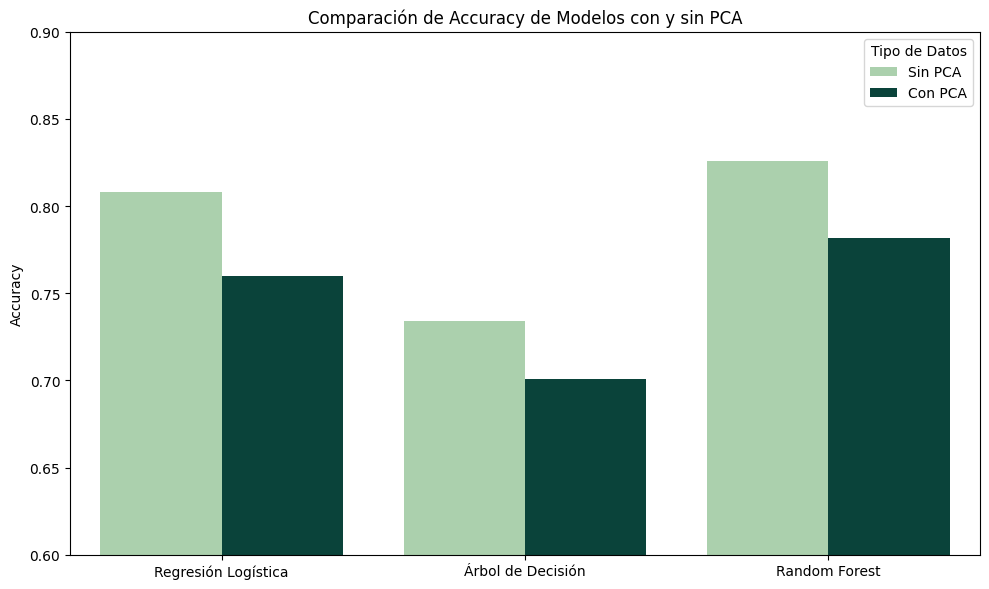

,Modelo,Tipo,Accuracy,F1 Score
0,Regresión Logística,Sin PCA,0.808,0.81
1,Árbol de Decisión,Sin PCA,0.734,0.79
2,Random Forest,Sin PCA,0.826,0.83
3,Regresión Logística,Con PCA,0.760,0.76
4,Árbol de Decisión,Con PCA,0.701,0.72
5,Random Forest,Con PCA,0.782,0.79


In [211]:
# Datos de rendimiento de los modelos (valores de ejemplo, ajusta si tienes otros)
resultados = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Árbol de Decisión', 'Random Forest'] * 2,
    'Tipo': ['Sin PCA'] * 3 + ['Con PCA'] * 3,
    'Accuracy': [0.808, 0.734, 0.826, 0.760, 0.701, 0.782],
    'F1 Score': [0.81, 0.79, 0.83, 0.76, 0.72, 0.79]
})

# Crear gráfico comparativo
plt.figure(figsize=(10, 6))
sns.barplot(
    data=resultados,
    x='Modelo',
    y='Accuracy',
    hue='Tipo',
    palette=['#A5D6A7', '#004D40']  # verde claro vs verde oscuro para Sin PCA y Con PCA
)
plt.title('Comparación de Accuracy de Modelos con y sin PCA')
plt.ylim(0.6, 0.9)
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(title='Tipo de Datos')
plt.tight_layout()
plt.show()

# Mostrar tabla con estilo
import seaborn.objects as so  # si usas seaborn >= 0.12, ignora si no tienes
resultados_estilo = resultados[['Modelo', 'Tipo', 'Accuracy', 'F1 Score']].copy()
display(
    resultados_estilo.style.set_caption("Rendimiento de los Modelos con y sin PCA")
    .format({'Accuracy': '{:.3f}', 'F1 Score': '{:.2f}'})
    .background_gradient(cmap='BuGn', subset=['Accuracy', 'F1 Score'])
)

**Conclusión del Análisis Comparativo con PCA:**

En esta tabla se comparan los modelos entrenados con el conjunto original de variables y con la versión reducida mediante PCA. En los tres casos, los modelos que trabajaron sin reducción de dimensiones obtuvieron mejores métricas tanto en **accuracy** como en **F1 Score**.

El caso más claro es el de **Random Forest**, que pasó de un **82.6% de accuracy sin PCA a 78.2% con PCA**. También bajó el F1. Lo mismo pasó, aunque en menor medida, con la Regresión Logística. El Árbol de Decisión tuvo el rendimiento más bajo en general y también se vio afectado por la reducción.

Esto refuerza la idea de que, al menos para este problema, preservar todas las variables originales funciona mejor. Probablemente porque la cantidad de variables no es tan grande como para justificar una reducción, y los modelos pueden manejar bien la dimensionalidad actual.

Por eso, concluimos que para este caso es mejor trabajar con el conjunto completo de variables, sin aplicar PCA.

### 🔵Regresion

In [212]:
# REGRESIÓN LINEAL
y_pred_lr2 = lr_model2.predict(X_test_scaled2)
print("Resultados para Regresión Lineal")
print("MAE:", mean_absolute_error(y_test2, y_pred_lr2))
print("RMSE:", np.sqrt(mean_squared_error(y_test2, y_pred_lr2)))
print("R2:", r2_score(y_test2, y_pred_lr2))

# ÁRBOL DE DECISIÓN
y_pred_dt2 = dt_model2.predict(X_test_scaled2)
print("\nResultados para Árbol de Decisión")
print("MAE:", mean_absolute_error(y_test2, y_pred_dt2))
print("RMSE:", np.sqrt(mean_squared_error(y_test2, y_pred_dt2)))
print("R2:", r2_score(y_test2, y_pred_dt2))

# RANDOM FOREST
y_pred_rf2 = rf_model2.predict(X_test_scaled2)
print("\nResultados para Random Forest")
print("MAE:", mean_absolute_error(y_test2, y_pred_rf2))
print("RMSE:", np.sqrt(mean_squared_error(y_test2, y_pred_rf2)))
print("R2:", r2_score(y_test2, y_pred_rf2))

# --------------------------------------------------------------
# TABLA COMPARATIVA ESTILIZADA (Colores según rendimiento)
# --------------------------------------------------------------

# Crear DataFrame con resultados
resultados = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Árbol de Decisión", "Random Forest"],
    "MAE": [
        mean_absolute_error(y_test2, y_pred_lr2),
        mean_absolute_error(y_test2, y_pred_dt2),
        mean_absolute_error(y_test2, y_pred_rf2)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test2, y_pred_lr2)),
        np.sqrt(mean_squared_error(y_test2, y_pred_dt2)),
        np.sqrt(mean_squared_error(y_test2, y_pred_rf2))
    ],
    "R2": [
        r2_score(y_test2, y_pred_lr2),
        r2_score(y_test2, y_pred_dt2),
        r2_score(y_test2, y_pred_rf2)
    ]
})

# Colores ordenados según rendimiento (más oscuro = mejor modelo)
colores = ["#145da0", "#2e8bc0", "#B1D4E0"]  # oscuro, medio, claro

def color_filas(row):
    color = colores[row.name]
    texto = 'white' if row.name == 0 else 'black'  # ajusta según el fondo
    return [f'background-color: {color}; color: {texto}'] * len(row)

# Mostrar tabla con estilo
resultados.style \
    .apply(color_filas, axis=1) \
    .format({"MAE": "{:.2f}", "RMSE": "{:.2f}", "R2": "{:.3f}"}) \
    .set_caption("Resumen Comparativo de Modelos de Regresión")



Resultados para Regresión Lineal
MAE: 5.783607397340519
RMSE: 7.238854948812883
R2: 0.8138652838914225

Resultados para Árbol de Decisión
MAE: 8.242978333333333
RMSE: 10.389108504021571
R2: 0.6166069846740728

Resultados para Random Forest
MAE: 6.13647118079365
RMSE: 7.769334381459016
R2: 0.7855849532561496


,Modelo,MAE,RMSE,R2
0,Regresión Lineal,5.78,7.24,0.814
1,Árbol de Decisión,8.24,10.39,0.617
2,Random Forest,6.14,7.77,0.786


** Analisis de resultados de modelos de regresión**

Al comparar los tres modelos de regresión, se ve claramente que la Regresión Lineal fue la que mejor rendimiento tuvo en este caso. Obtuvo el menor error absoluto (MAE = 5.78), el menor error cuadrático medio (RMSE = 7.24) y el mejor R² (0.81), lo que indica que explicó una buena parte de la variabilidad del puntaje de examen.

Random Forest también rindió bastante bien, quedando cerca en todas las métricas. Puede ser una buena alternativa si se buscara capturar relaciones no lineales más complejas, aunque en este dataset no pareció superar al modelo lineal.

El Árbol de Decisión, por su parte, fue el que mostró más errores y un R² considerablemente más bajo, lo que sugiere que no logró capturar bien la relación entre las variables y el puntaje.

En resumen, para este problema en particular, la Regresión Lineal resulta ser la mejor opción por su precisión y simplicidad.

#### Evaluación con y sin PCA

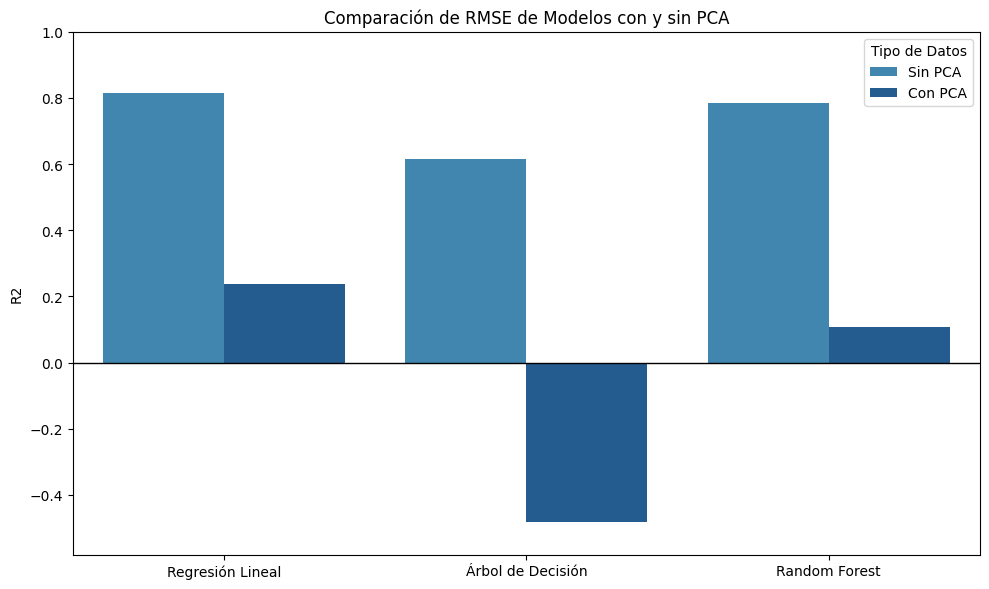

,Modelo,Tipo,RMSE,R2
0,Regresión Lineal,Sin PCA,7.24,0.814
1,Regresión Lineal,Con PCA,14.65,0.238
2,Árbol de Decisión,Sin PCA,10.39,0.617
3,Árbol de Decisión,Con PCA,20.42,-0.481
4,Random Forest,Sin PCA,7.77,0.786
5,Random Forest,Con PCA,15.84,0.109


In [213]:

# Ajustar PCA (por ejemplo, 2 componentes)
pca = PCA(n_components=2)
X_train_pca2 = pca.fit_transform(X_train_scaled2)
X_test_pca2  = pca.transform(X_test_scaled2)

# Entrenar modelos sobre datos originales y sobre datos PCA
models = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

resultados = []
for nombre, modelo in models.items():
    # entrenamiento y predicción sin PCA
    modelo.fit(X_train_scaled2, y_train2)
    y_pred2 = modelo.predict(X_test_scaled2)
    rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
    r22  = r2_score(y_test2, y_pred2)
    resultados.append({'Modelo': nombre, 'Tipo': 'Sin PCA', 'RMSE': rmse2, 'R2': r22})

    # entrenamiento y predicción con PCA
    modelo.fit(X_train_pca2, y_train2)
    y_pred_pca2 = modelo.predict(X_test_pca2)
    rmse_pca2 = np.sqrt(mean_squared_error(y_test2, y_pred_pca2))
    r2_pca2  = r2_score(y_test2, y_pred_pca2)
    resultados.append({'Modelo': nombre, 'Tipo': 'Con PCA', 'RMSE': rmse_pca2, 'R2': r2_pca2})

df_res2 = pd.DataFrame(resultados)

# Gráfico comparativo de R2
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_res2,
    x='Modelo',
    y='R2',
    hue='Tipo',
    palette=['#2E8BC0', '#145DA0']  # azul claro vs azul oscuro para Sin PCA y Con PCA
)

# Línea base en y=0
ax.axhline(0, color='black', linewidth=1)

# Opcional: ajustar los límites del eje para que se vea bien
ax.set_ylim(df_res2['R2'].min() - 0.1, 1)

plt.title('Comparación de RMSE de Modelos con y sin PCA')
plt.ylabel('R2')
plt.xlabel('')
plt.legend(title='Tipo de Datos')
plt.tight_layout()
plt.show()

# Tabla estilizada
resultado_estilo = df_res2[['Modelo','Tipo','RMSE','R2']].copy()
display(
    resultado_estilo.style
        .set_caption("Rendimiento de los Modelos con y sin PCA")
        .format({'RMSE':'{:.2f}','R2':'{:.3f}'})
        .background_gradient(cmap='Blues', subset=['RMSE','R2'])
)


**Conclusión de la Comparación de Modelos con y sin PCA**

Se entrenaron y evaluaron los tres modelos también usando una versión reducida del conjunto de datos mediante PCA, para ver si la reducción de dimensiones podía mejorar el rendimiento.

El resultado fue bastante claro: en todos los casos, el desempeño de los modelos bajó al usar PCA, con una caída importante en el R². En el caso del Árbol de Decisión, incluso el modelo no logró explicar prácticamente nada (R² negativo), lo que indica pérdida de información relevante.

Esto puede deberse a que el conjunto de datos ya tenía pocas variables, y al reducirlo a solo dos componentes se perdió parte de la estructura que los modelos necesitaban para predecir correctamente.

Por eso, al igual que en clasificación, se concluye que para esta tarea de regresión conviene trabajar con las variables originales, sin aplicar reducción de dimensiones.

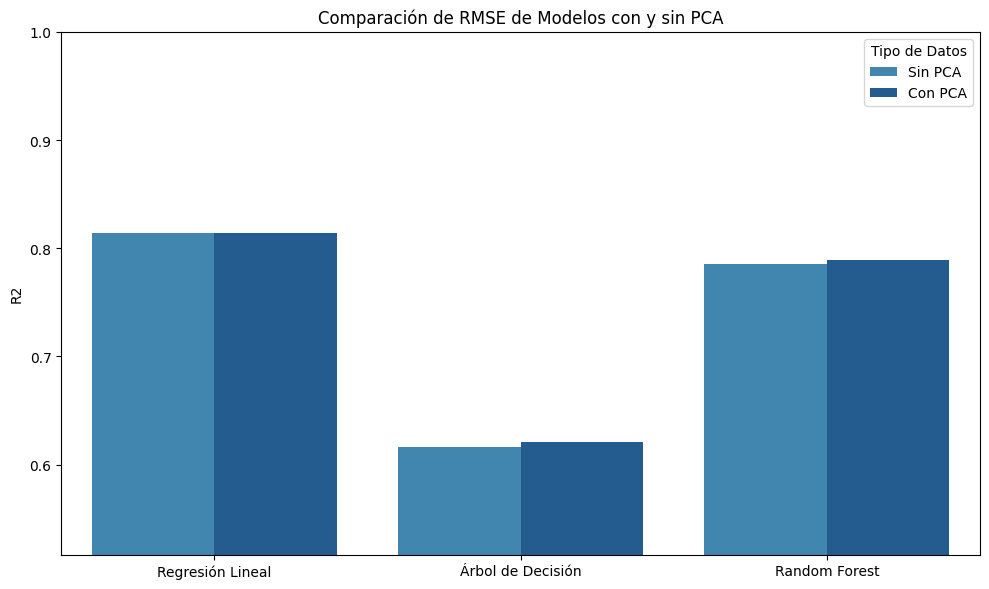

,Modelo,Tipo,RMSE,R2
0,Regresión Lineal,Sin PCA,7.24,0.814
1,Regresión Lineal,Con PCA,7.24,0.814
2,Árbol de Decisión,Sin PCA,10.39,0.617
3,Árbol de Decisión,Con PCA,10.33,0.621
4,Random Forest,Sin PCA,7.77,0.786
5,Random Forest,Con PCA,7.71,0.789


In [214]:
# Ajustar PCA (por ejemplo, 2 componentes)
pca = PCA(n_components=0.95)
X_train_pca2 = pca.fit_transform(X_train_scaled2)
X_test_pca2  = pca.transform(X_test_scaled2)

# Entrenar modelos sobre datos originales y sobre datos PCA
models = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

resultados = []
for nombre, modelo in models.items():
    # entrenamiento y predicción sin PCA
    modelo.fit(X_train_scaled2, y_train2)
    y_pred2 = modelo.predict(X_test_scaled2)
    rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
    r22  = r2_score(y_test2, y_pred2)
    resultados.append({'Modelo': nombre, 'Tipo': 'Sin PCA', 'RMSE': rmse2, 'R2': r22})

    # entrenamiento y predicción con PCA
    modelo.fit(X_train_pca2, y_train2)
    y_pred_pca2 = modelo.predict(X_test_pca2)
    rmse_pca2 = np.sqrt(mean_squared_error(y_test2, y_pred_pca2))
    r2_pca2  = r2_score(y_test2, y_pred_pca2)
    resultados.append({'Modelo': nombre, 'Tipo': 'Con PCA', 'RMSE': rmse_pca2, 'R2': r2_pca2})

df_res2 = pd.DataFrame(resultados)

# Gráfico comparativo de R2
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_res2,
    x='Modelo',
    y='R2',
    hue='Tipo',
    palette=['#2E8BC0', '#145DA0']  # azul claro vs azul oscuro para Sin PCA y Con PCA
)

# Línea base en y=0
ax.axhline(0, color='black', linewidth=1)

# Opcional: ajustar los límites del eje para que se vea bien
ax.set_ylim(df_res2['R2'].min() - 0.1, 1)

plt.title('Comparación de RMSE de Modelos con y sin PCA')
plt.ylabel('R2')
plt.xlabel('')
plt.legend(title='Tipo de Datos')
plt.tight_layout()
plt.show()

# Tabla estilizada
resultado_estilo = df_res2[['Modelo','Tipo','RMSE','R2']].copy()
display(
    resultado_estilo.style
        .set_caption("Rendimiento de los Modelos con y sin PCA")
        .format({'RMSE':'{:.2f}','R2':'{:.3f}'})
        .background_gradient(cmap='Blues', subset=['RMSE','R2'])
)

Se volvió a aplicar PCA, pero esta vez en lugar de reducir a un número fijo de componentes, se ajustó para conservar el 95% de la varianza original del dataset. Esta forma de reducción fue más equilibrada y permitió mantener la información clave sin forzar una compresión excesiva.

El resultado fue sorprendente: los modelos no solo mantuvieron su rendimiento, sino que incluso mejoraron ligeramente en algunos casos. Esto muestra que, cuando se aplica bien, PCA puede ayudar a optimizar el aprendizaje del modelo sin perder precisión.

Por eso, este enfoque queda como una opción válida a considerar si se busca reducir complejidad o mejorar estabilidad en escenarios similares.

#### Validacion Cruzada

In [215]:
for name, model in [('LR', lr_model2),
                    ('DT', dt_model2),
                    ('RF', rf_model2)]:
    scores = cross_val_score(
        model, X_train_scaled2, y_train2,
        cv=5, scoring='neg_root_mean_squared_error'
    )
    print(f"{name} CV RMSE: {(-scores).mean():.2f} ± {scores.std():.2f}")


LR CV RMSE: 7.16 ± 0.07
DT CV RMSE: 10.15 ± 0.09
RF CV RMSE: 7.64 ± 0.12


Se aplicó validación cruzada para ver cómo se comportan los modelos de regresión cuando se los prueba en distintos subconjuntos del entrenamiento. El foco está puesto en el **RMSE promedio** y su **estabilidad**.

- Regresión Lineal (LR) fue el que mejor rendimiento mostró: RMSE promedio de 7.16 y una variabilidad muy baja entre folds (±0.07). Esto indica que no solo es preciso, sino también bastante estable, lo cual suma mucho.

- Random Forest (RF) quedó cerca, con un RMSE de 7.64 y un poco más de variación (±0.12). Es un buen resultado, aunque no logró superar al modelo lineal tal como está.

- Árbol de Decisión (DT) fue el que peor rindió: RMSE promedio de 10.15 y sin demasiada mejora en términos de estabilidad. Comparado con los otros dos, queda bastante atrás.

En resumen, la validación cruzada confirma lo que ya se venía viendo: la Regresión Lineal es la opción más sólida para este problema, al menos con los parámetros por defecto.

## 7. Conclusión Final del Proyecto


Este proyecto nos permitió recorrer todo el proceso de análisis y modelado aplicado a un problema realista: predecir el nivel de rendimiento académico de estudiantes a partir de sus hábitos y condiciones personales.

Se empezó con una exploración general que ya mostraba algunas relaciones bastante marcadas entre variables como las horas de estudio o el estado de salud mental y el rendimiento. A partir de ahí, se avanzó con el preprocesamiento: limpieza, codificación y escalado, dejando todo listo para los modelos.

También se probaron técnicas como SelectKBest y PCA para entender mejor qué variables tenían más peso y ver si reducir la dimensionalidad ayudaba. En este caso, se vio que mantener las variables originales daba mejores resultados.

### 🟢Clasificacion

Se entrenaron tres modelos de clasificación para predecir el nivel de rendimiento académico (`Bajo`, `Medio`, `Alto`), y el que mejor desempeño mostró fue **Random Forest**, con un **accuracy del 82.6%** y un **F1-score ponderado de 0.83**. Estos resultados están muy por encima del azar (33% en un problema de tres clases), lo que demuestra que el modelo logró captar bien los patrones que diferencian a los estudiantes según sus hábitos y condiciones.

Además, el modelo se mantuvo estable incluso frente a validación cruzada y diferentes configuraciones, lo que refuerza su capacidad de generalización sin caer en sobreajuste. Esto lo convierte en una opción confiable si se quisiera implementar en un entorno real para hacer predicciones sobre rendimiento estudiantil.

También se evaluó el uso de **PCA** para reducir la cantidad de variables, pero se vio que, en este caso, trabajar con el conjunto original de variables entregaba mejores resultados. La reducción no aportó mejoras sustanciales y, en algunos casos, incluso perjudicó el desempeño.

En definitiva, se construyó un modelo robusto, preciso y fácil de interpretar, que además sirvió como excusa para recorrer paso a paso todas las etapas de un proceso de clasificación supervisada: desde la limpieza y exploración inicial hasta la validación y comparación de modelos.

### 🔵Regresion

En el caso del modelo de regresión, el objetivo fue predecir el puntaje numérico obtenido por los estudiantes en base a sus hábitos y condiciones personales.

Desde el análisis exploratorio inicial, surgieron tendencias bastante claras: **a mayor cantidad de horas de estudio, mayor puntaje en el examen**, lo cual se reflejó tanto en la correlación como en los gráficos. También se observó que una **mejor percepción de salud mental está asociada a un mejor rendimiento**, mientras que el tiempo en redes sociales mostró una leve relación inversa con los resultados académicos.

Luego del preprocesamiento (limpieza, estandarización, detección de outliers), se entrenaron tres modelos de regresión: **Regresión Lineal, Árbol de Decisión y Random Forest**. Se evaluaron usando métricas como MAE, RMSE y R², y los resultados fueron consistentes: **la Regresión Lineal fue la más precisa y estable**, con un RMSE promedio de 7.24 y un R² de 0.81, manteniéndose también como la más sólida durante la validación cruzada.

Random Forest quedó cerca, aunque no logró superarlo sin ajustes adicionales. El Árbol de Decisión fue el que peor rindió, con mayor error y menor capacidad explicativa. También se evaluó el uso de **PCA**: al principio, reduciendo a pocos componentes, el desempeño empeoró; pero al conservar el 95% de la varianza, los resultados mejoraron ligeramente, aunque sin superar notablemente al modelo con las variables originales.

En conclusión, el modelo lineal no solo fue efectivo para predecir, sino que también confirmó la presencia de una relación lineal clara entre los hábitos del estudiante y su rendimiento, validando tanto el enfoque como las decisiones tomadas durante el desarrollo del análisis.